# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import authentic_performance as ap
from scipy.stats import uniform, norm
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch_geometric.utils as utils
from torch.utils.data import DataLoader

In [3]:
def power_law(x, a=1):
    return (1/x)**a

In [81]:
N = 100
P = 10/N
DISTRIBUTION = uniform

FRAUD = True
FRAUD_PROBABILITY = 0.7
FRAUDSTER_INDEX = round(N/2)  # or round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()
FRAUD_SCHEME = "strength"  # "strength" or None

STRENGTH_SCHEME = False
ITERATIONS = 10000  # strength scheme iterations
DECREASING_FUNCTION = lambda x : power_law(x, 3)  # decreasing function for strength scheme

G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=FRAUD_PROBABILITY,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)

nx.set_node_attributes(G, {k:{"delta_degrees_in_out":v} for k, v in dict(pd.Series(dict(G.in_degree())) - pd.Series(dict(G.out_degree()))).items()})
nx.set_node_attributes(G, {k:{"pr":v} for k,v in nx.pagerank(G).items()})
nx.write_gexf(G, "gephi_viz/synthetic.gexf")

In [5]:
def generate_networkFraudFree():
    return  ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=False,
                     fraudster_index=None,
                     fraudster_strength=None,
                     fraud_probability=None,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)

# 1. Random network, dumb frauder

In [90]:
N = 100
P = 10/N
DISTRIBUTION = uniform

FRAUD = True
FRAUD_PROBABILITY = 0.7
FRAUDSTER_INDEX = round(N/2)  # or round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()
FRAUD_SCHEME = None  # "strength" or None

STRENGTH_SCHEME = False
ITERATIONS = 10000  # strength scheme iterations
DECREASING_FUNCTION = lambda x : power_law(x, 3)  # decreasing function for strength scheme

## 1.1 Delta degrees ranking

### Ranking performance

In [154]:
ranking_true = np.arange(100)
a_ranking_distances = np.array([ap.kendall_tauDistance(ranking_true,np.argsort(ap.rate_deltaDegrees(generate_networkFraudFree()))) for _ in range(1000)])
np.mean(a_ranking_distances), np.std(a_ranking_distances)

(722.287, 55.56209707165488)

### Fraud sensitivity

In [155]:
l_fraudster_index = [20, 50, 80]
l_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
l3 = []
for fraudster_index in l_fraudster_index:
    l2 = []
    for fraud_proba in l_fraud_probabilities:
        l1 = []
        for _ in range(100):
            G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=fraudster_index,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=fraud_proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
            a_delta_degrees = ap.rate_deltaDegrees(G)  # rating function
            l1.append(a_delta_degrees)
        l2.append(np.stack(l1).mean(axis=0))
    l3.append(np.stack(l2))
output = np.stack(l3)

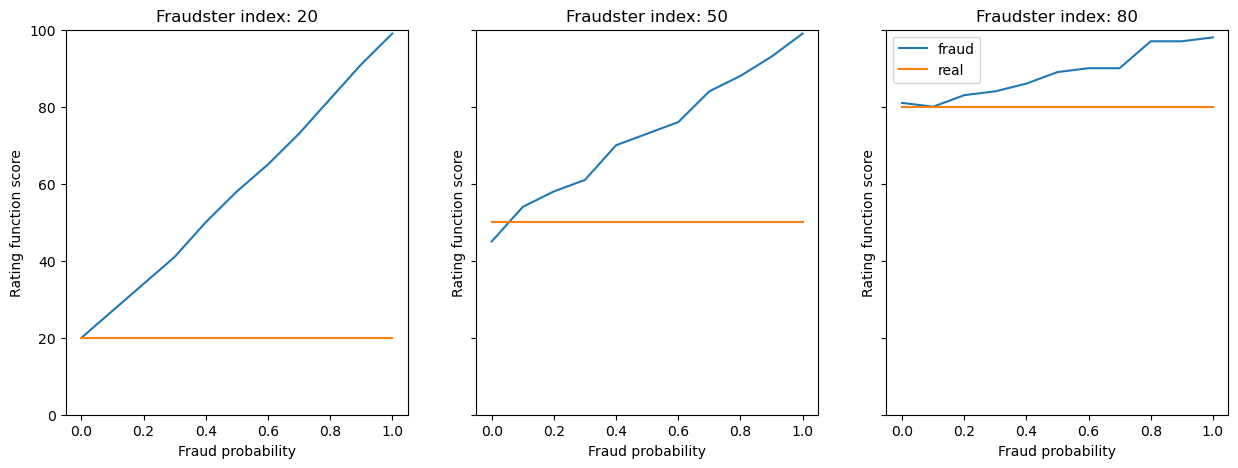

In [158]:
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
for i, fraudster_index in enumerate(l_fraudster_index):
    ax[i].plot(l_fraud_probabilities, np.nonzero((np.argsort(output[i, :, :], axis=1)==fraudster_index))[1], label="fraud")
    ax[i].plot(l_fraud_probabilities, [fraudster_index for _ in l_fraud_probabilities], label="real")
    ax[i].set_title(f"Fraudster index: {fraudster_index}")
    ax[i].set_xlabel("Fraud probability")
    ax[i].set_ylabel("Rating function score")
    ax[i].set_ylim(0,N)
plt.legend()

There is a linear relationship between the proportion of fraudulous links and the expected improvement of the rank which comes from the fact that the delta degree function is linear wrt the proportion of fraudulous links. Clearly the delta degree rating function is sensible to this kind of fraud.

## 1.2 $f_{\alpha,t}$

### Training of $f_{\alpha,t}$
Optimization of parameters $\alpha$ and $t$ on fraudster free synthetic networks.

In [193]:
X, y = ap.generate_trainingData(generate_networkFraudFree, n=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [194]:
model = ap.WinLossDraw()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=5e-1)

Mean squared error on test set: 0.028744840994477272


(array([24., 16., 20., 21.,  9., 24., 15., 20., 17., 34.]),
 array([0.28224894, 0.32579917, 0.36934936, 0.41289958, 0.45644981,
        0.5       , 0.54355025, 0.58710045, 0.63065064, 0.67420089,
        0.71775109]),
 <BarContainer object of 10 artists>)

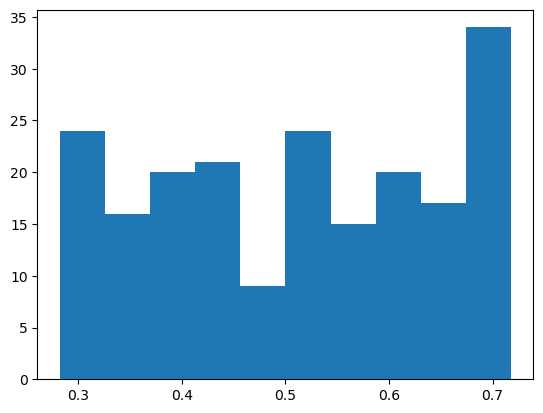

In [195]:
# before training
output = model(X_test)
print(f"Mean squared error on test set: {((output-y_test)**2).sum()/len(y_test)}")
plt.hist(output.detach().numpy())

In [196]:
l_losses = []
l_param = []
for i in range(30000):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    l_losses.append(loss.item())
    l_param.append((model.alpha.item(), model.t.item()))

Text(0.5, 1.0, 'Offset t')

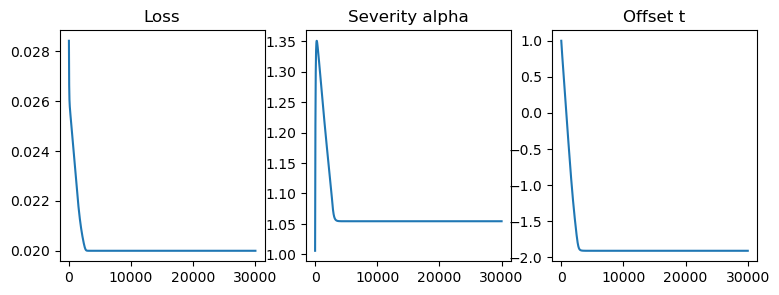

In [197]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].plot(l_losses)
ax[0].set_title("Loss")
ax[1].plot([x[0] for x in l_param])
ax[2].plot([x[1] for x in l_param])
ax[1].set_title("Severity alpha")
ax[2].set_title("Offset t")

Mean squared error on test set: 0.02089580148458481


(array([ 2., 14., 26., 28., 26., 25., 27., 29., 20.,  3.]),
 array([0.05221608, 0.14097989, 0.22974369, 0.31850749, 0.4072713 ,
        0.4960351 , 0.58479893, 0.67356271, 0.76232654, 0.85109031,
        0.93985415]),
 <BarContainer object of 10 artists>)

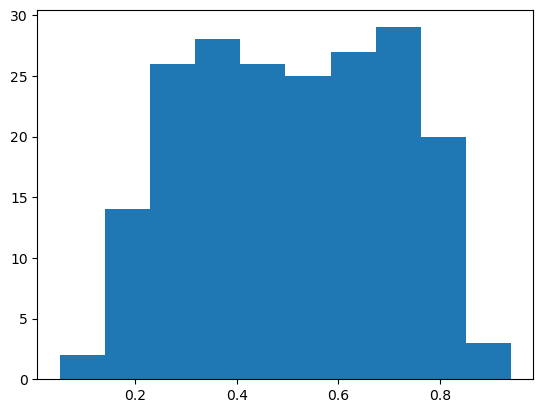

In [198]:
output = model(X_test)
print(f"Mean squared error on test set: {((output-y_test)**2).sum()/len(y_test)}")
plt.hist(output.detach().numpy())

### Ranking performance

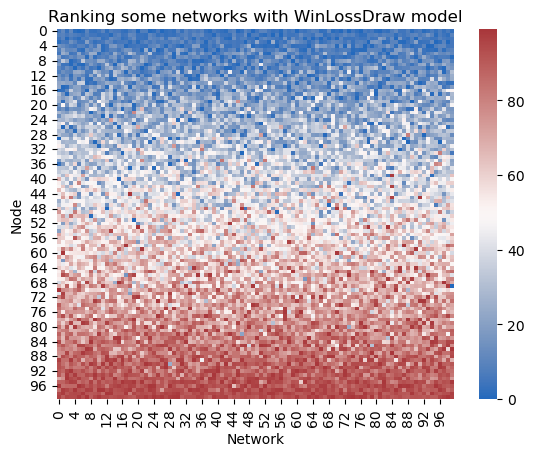

In [226]:
l_series = []
for _ in range(100):
    G = generate_networkFraudFree()

    df = ap.convert_graphToDataFrame(G)
    df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
    l_series.append(df["pred_strength"].rank() -1)

ax = sns.heatmap(pd.concat(l_series, axis=1).values,
            cmap=sns.color_palette("vlag", as_cmap=True)).set(xlabel='Network', ylabel='Node', title = "Ranking some networks with WinLossDraw model");

We can see that the WinLossDraw model performs very well on average.

In [219]:
l = []
for _ in range(1000):
    G = generate_networkFraudFree()
    t_ratings = model(torch.from_numpy(ap.convert_graphToDataFrame(G)[["wins", "losses", "draws"]].values))
    a_ranking_true = np.arange(100)
    a_rankings = np.array(torch.argsort(t_ratings))
    l.append(ap.kendall_tauDistance(a_ranking_true, a_rankings))
a_ranking_distances = np.array(l)
np.mean(a_ranking_distances), np.std(a_ranking_distances)

(649.3856143856144, 62.08921067918635)

### Fraud sensitivity

In [223]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        l.append(df["pred_strength"].rank() -1)
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

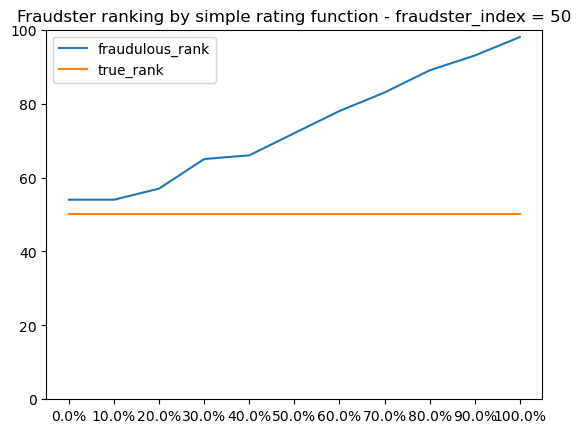

In [225]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking by simple rating function - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

We can see that the function simple rating is fooled by the fraudster. It appears that the pattern is also linear.

## 1.3.A MLP rater

### Training

In [105]:
X, y = ap.generate_trainingData(generate_networkFraudFree, n=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

In [107]:
model = MLP(3, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)

In [108]:
n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    # print(f"Epoch {epoch}")
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Batch {i} - loss = {loss_train.item()}")
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    # print(f"\nTest loss = {loss_test.item()}")

Text(0.5, 1.0, 'Test')

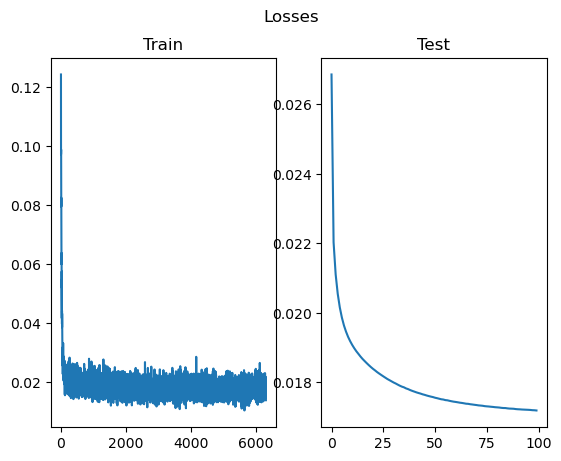

In [109]:
fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

### Ranking efficiency

In [110]:
l = []
for _ in range(1000):
    G = generate_networkFraudFree()
    df = ap.convert_graphToDataFrame(G)
    a_ranking_true = df.index.values
    t_ratings = model(torch.from_numpy(df[["wins", "losses", "draws"]].values).float())
    a_rankings = np.array(torch.argsort(t_ratings.flatten()))
    l.append(ap.kendall_tauDistance(a_ranking_true, a_rankings))
a_ranking_distances = np.array(l)
np.mean(a_ranking_distances), np.std(a_ranking_distances)

(698.579, 53.68498634627749)

### Fraud sensitivity

In [ ]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        
        df = ap.convert_graphToDataFrame(G)
        df["pred_strength"] = model(torch.tensor(df[["wins","losses","draws"]].values, dtype=torch.float)).detach().numpy()
        l.append(df["pred_strength"].rank() -1)
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

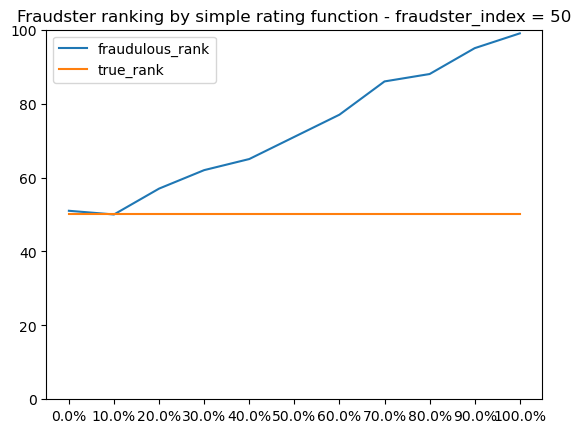

In [ ]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking by simple rating function - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

## 1.3.B MLP rater with neighbor information

### Training

In [147]:
l_X, l_y = [], []
for _ in range(100):
    G = generate_networkFraudFree()
    adjacency = nx.adjacency_matrix(G).todense()
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    l_X.append(X)
    l_y.append(y)
X = torch.tensor(np.concatenate(l_X), dtype=torch.float)
y = torch.tensor(np.concatenate(l_y), dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=128, shuffle=True)

/tmp/ipykernel_4700/1815881219.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_4700/1815881219.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
/tmp/ipykernel_4700/1815881219.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_4700/1815881219.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense()
/tmp/ipykernel_4700/1815881219.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_4

In [148]:
model = MLP(4, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Text(0.5, 1.0, 'Test')

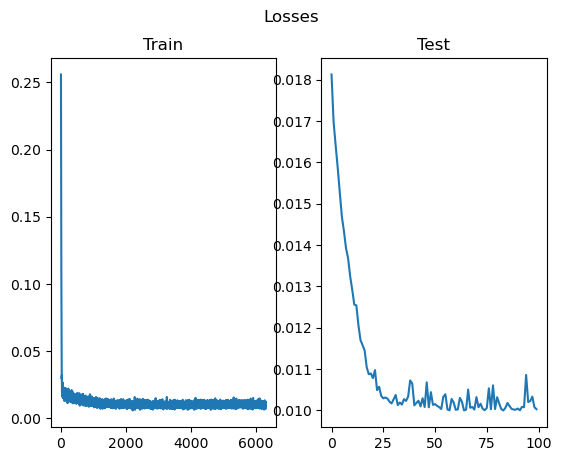

In [150]:
n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model.train()
    # print(f"Epoch {epoch}")
    for i, (data, labels) in enumerate(train_loader):
        pred = model(data).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Batch {i} - loss = {loss_train.item()}")
    model.eval()
    pred = model(X_test).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    # print(f"\nTest loss = {loss_test.item()}")

fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

Comparison with standard MLP, trained on same input data (except neigbourhood information) \
The two confidence intervals don't overlap so we can say **there is an interest in looking at topological information**

In [152]:
model_standard = MLP(3, 100)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_standard.parameters(), lr=1e-3)

Text(0.5, 1.0, 'Test')

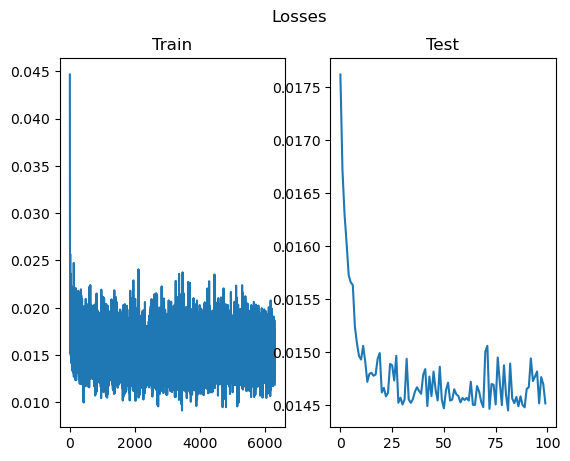

In [153]:
n_epoch = 100

l_train_loss = []
l_test_loss = []
for epoch in range(n_epoch):
    model_standard.train()
    # print(f"Epoch {epoch}")
    for i, (data, labels) in enumerate(train_loader):
        pred = model_standard(data[:,:3]).flatten()
        loss_train = criterion(pred, labels)
        loss_train.backward()
        l_train_loss.append(loss_train.item())
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Batch {i} - loss = {loss_train.item()}")
    model_standard.eval()
    pred = model_standard(X_test[:,:3]).flatten()
    loss_test = criterion(pred, y_test)
    l_test_loss.append(loss_test.item())
    # print(f"\nTest loss = {loss_test.item()}")

fig, ax = plt.subplots(1,2)
plt.suptitle("Losses")
ax[0].plot(l_train_loss, label="train")
ax[0].set_title("Train")
ax[1].plot(l_test_loss, label="test")
ax[1].set_title("Test")

In [154]:
l = []
l_standard = []
for _ in range(1000):
    G = generate_networkFraudFree()
    adjacency = nx.adjacency_matrix(G).todense();
    adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
    wins = np.array(adjacency.T.sum(axis=1)).flatten()
    losses = np.array(adjacency.sum(axis=1)).flatten()
    draws = np.zeros_like(wins)
    neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
    y = np.array(list(nx.get_node_attributes(G, "strength").values()))
    X = np.stack((wins, losses, draws, neighbourhood_strength), axis=1)
    a_ranking_true = np.array(G.nodes)
    
    # mlp with neighbourhood information
    t_ratings = model(torch.from_numpy(X).float())
    a_rankings = np.array(torch.argsort(t_ratings.flatten()))
    l.append(ap.kendall_tauDistance(a_ranking_true, a_rankings))
    
    # standard mlp
    t_ratings_standard = model_standard(torch.from_numpy(X[:,:3]).float())
    a_rankings_standard = np.array(torch.argsort(t_ratings_standard.flatten()))
    l_standard.append(ap.kendall_tauDistance(a_ranking_true, a_rankings_standard))

a_ranking_distances_standard = np.array(l_standard)
a_ranking_distances = np.array(l)

/tmp/ipykernel_4700/3688254121.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_4700/3688254121.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_4700/3688254121.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipykernel_4700/3688254121.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
/tmp/ipykernel_4700/3688254121.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense();
/tmp/ipyker

In [157]:
print(f"MLP standard:\nmean={np.mean(a_ranking_distances_standard)}, std={np.std(a_ranking_distances_standard)}")
print(f"\nMLP with neighbourhood information:\nmean={np.mean(a_ranking_distances)}, std={np.std(a_ranking_distances)}")

MLP standard:
mean=628.735, std=53.01992809312363

MLP with neighbourhood information:
mean=483.389, std=43.04971171796624


In [ ]:
# result is significative
print(f"Upper bound of mean kendall tau distance to perfect ranking for MLP with neighbourhood information : {np.mean(a_ranking_distances) + 1.96 * np.std(a_ranking_distances) / np.sqrt(1000)}")
print(f"Lower bound of mean kendall tau distance to perfect ranking for standard MLP  : {np.mean(a_ranking_distances_standard) - 1.96 * np.std(a_ranking_distances_standard) / np.sqrt(1000)}")

Upper bound of mean kendall tau distance to perfect ranking for MLP with neighbourhood information : 490.56890562942004
Lower bound of mean kendall tau distance to perfect ranking for standard MLP  : 627.7322907391384


### Fraud sensitivity

In [ ]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(10):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        adjacency = nx.adjacency_matrix(G).todense();
        adjacency_undirected = nx.adjacency_matrix(G.to_undirected()).todense();
        wins = np.array(adjacency.T.sum(axis=1)).flatten()
        losses = np.array(adjacency.sum(axis=1)).flatten()
        draws = np.zeros_like(wins)
        neighbourhood_strength = np.array(np.dot(adjacency_undirected, adjacency.T).sum(axis=1)).flatten() / np.array(np.dot(adjacency_undirected, adjacency_undirected).sum(axis=1)).flatten()
        X = torch.from_numpy(np.stack((wins, losses, draws, neighbourhood_strength), axis=1)).float()
        s = pd.Series(data=model(X).detach().numpy().flatten(), index=G.nodes()).sort_index()
        l.append(s.rank()-1)
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

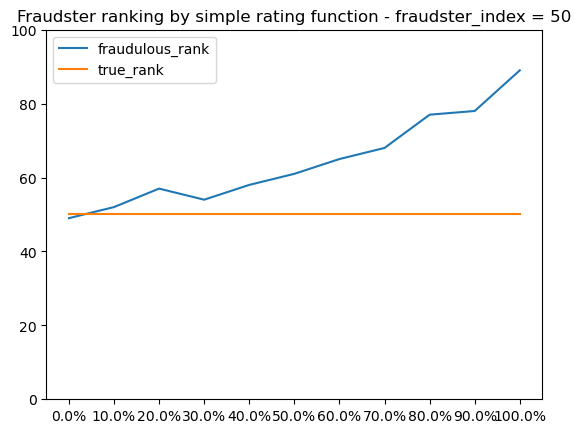

In [ ]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking by simple rating function - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

### Bonus

Text(0.5, 1.0, 'Impact of neighboorhood performance on rating')

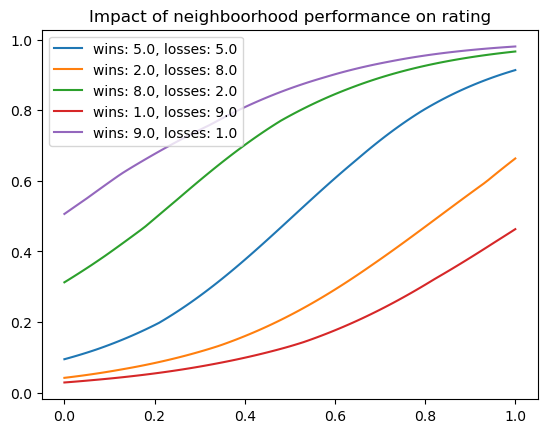

In [57]:
for wins, losses in [(5.,5.),  (2.,8.), (8.,2.), (1.,9.), (9.,1.)]:
    t1 = torch.permute(torch.tensor([wins, losses, 0.], requires_grad=False).repeat(101,1), (1,0))
    t2 = torch.permute(torch.linspace(0,1,101).view(101,1), (1,0))
    data = torch.permute(torch.concat((t1,t2)), (1,0))
    plt.plot(data[:,3], model(data).detach().numpy(), label=f"wins: {wins}, losses: {losses}")
plt.legend()
plt.title("Impact of neighboorhood performance on rating")

## 1.4 PageRank

### Ranking efficiency

In [ ]:
n_iter = 1000

l, l_alpha = [], []
a_ranking_true = np.arange(N)
alpha_values = list(np.linspace(0.1, 0.9, 9)) + [0.99, 0.999, 1.]
for alpha in alpha_values:
    for _ in range(n_iter):
        G = generate_networkFraudFree()
        pr = nx.pagerank(G, alpha=alpha, max_iter=10000)
        t_ratings = torch.tensor(list((pr.values())))
        a_rankings = np.array(torch.argsort(t_ratings.flatten()))
        l.append(ap.kendall_tauDistance(a_ranking_true, a_rankings))
    a_ranking_distances = np.array(l)
    l_alpha.append((np.mean(a_ranking_distances), np.std(a_ranking_distances)))

Text(0, 0.5, 'kendall tau distance (to best permutation)')

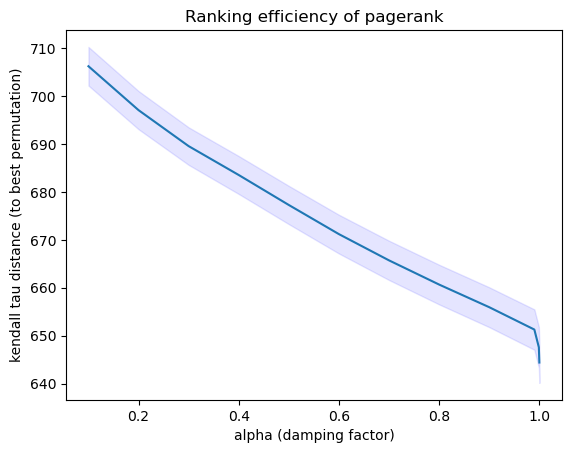

In [159]:
y = [x[0] for x in l_alpha]
plt.plot(alpha_values, y)
ci = 1.96 * np.array([x[1]/np.sqrt(n_iter) for x in l_alpha])
plt.fill_between(alpha_values, (y-ci), (y+ci), color='b', alpha=.1)
plt.title("Ranking efficiency of pagerank")
plt.xlabel("alpha (damping factor)")
plt.ylabel("kendall tau distance (to best permutation)")

Interestingly, the pagerank does not achieve better performance on on random network than an MLP, and is far from an MLP with neighbourhood. This is surprising because the immediate neighbourhood information made quite an impact when considering MLPs, even with this information restricted to direct neighbours. Since pagerank can leverage all orders of neighbourhoods, it would perhaps be expected that it had more expressive power however it seems not to be the case. It also seems that the lowest the damping factor, the better the ranking efficiency which indicates that longer dependencies are of interest.

### Fraud sensitivity

In [97]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        pr = nx.pagerank(G)
        s = pd.Series(pr)
        l.append(s.rank()-1)
    list_series.append(pd.concat(l, axis=1).mean(axis=1))

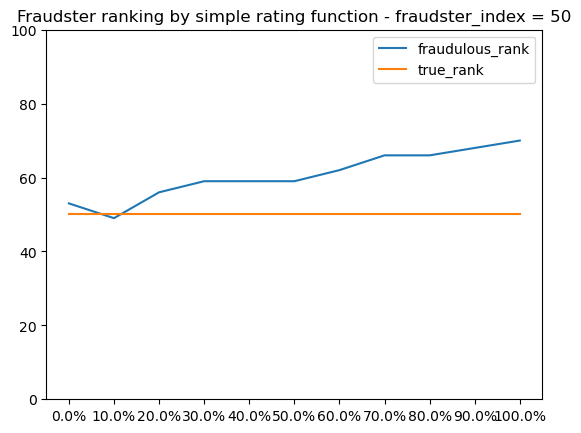

In [98]:
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series], label="fraudulous_rank")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_rank")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.title(f"Fraudster ranking by simple rating function - fraudster_index = {FRAUDSTER_INDEX}")
plt.legend()

## 1.5 GNN

Rater framed as a node level regression task

## 1.6 Fraud detection with Credible PageRank

# 2. Random Network, malicious fraudster

This time the fraudster selects opponents that are weaker but tend to match his strength level.

# 3. Strength-scheme Network, dumb fraudster

Strength scheme means the network is rewired to simulate a matchmaking process that tend to match nodes with comparable strength. The interpolation is continuous between a random network and strength-schemes.

# 4. Strength-scheme, malicious fraudster

## Experiment 1
Fraudster is set to be at median strength ie half on nodes have an inferior strength and half of nodes have a superior one. The fraudster is allowed to pick a proportion of his opponents that he knows to be weaker.

### Fraudster vs PageRank ratings

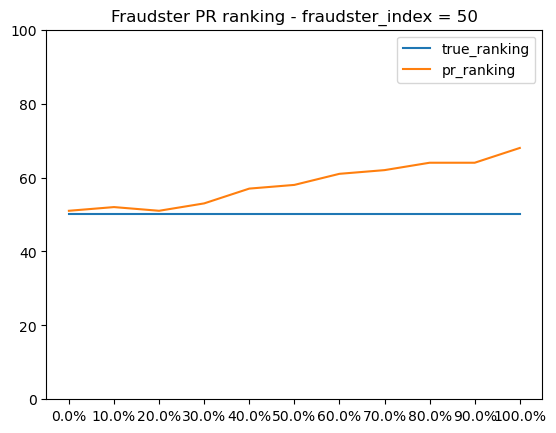

In [8]:
N = 100
DISTRIBUTION = uniform
P = 10/N
FRAUDSTER_INDEX = round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_pr = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(n=N, p=P, distribution=DISTRIBUTION, fraudster_index=FRAUDSTER_INDEX, fraudster_strength=FRAUDSTER_STRENGTH,
                                fraud_probability=proba)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    list_series_pr.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series_pr], label="true_ranking")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_pr], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

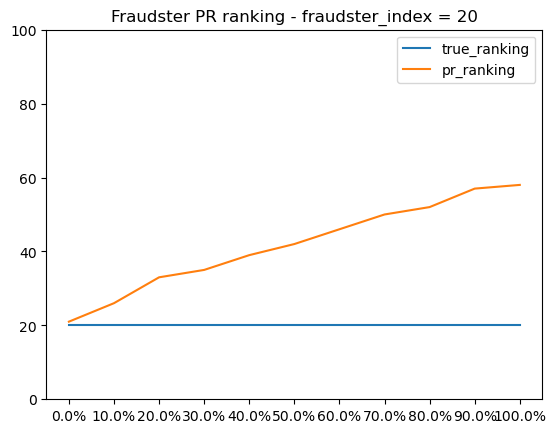

In [9]:
N = 100
DISTRIBUTION = uniform
P = 10/N
FRAUDSTER_INDEX = 20
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_pr = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(n=N, p=P, distribution=DISTRIBUTION, fraudster_index=FRAUDSTER_INDEX, fraudster_strength=FRAUDSTER_STRENGTH,
                                fraud_probability=proba)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    list_series_pr.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series_pr], label="true_ranking")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_pr], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

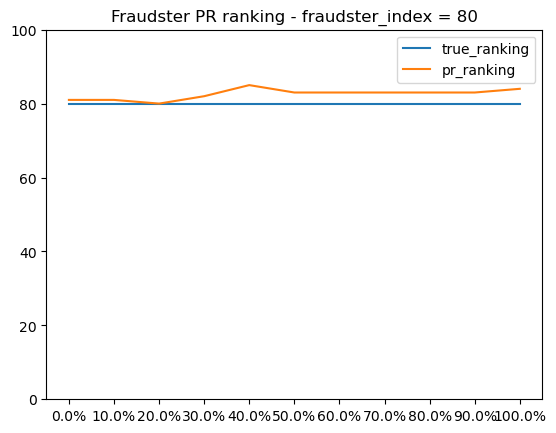

In [10]:
N = 100
DISTRIBUTION = uniform
P = 10/N
FRAUDSTER_INDEX = 80
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series_pr = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(n=N, p=P, distribution=DISTRIBUTION, fraudster_index=FRAUDSTER_INDEX, fraudster_strength=FRAUDSTER_STRENGTH,
                                fraud_probability=proba)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    list_series_pr.append(pd.concat(l, axis=1).mean(axis=1).sort_index())

plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series_pr], label="true_ranking")
plt.plot([np.nonzero(l.sort_values().index == FRAUDSTER_INDEX)[0][0] for l in list_series_pr], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

PageRank is not fooled as much as the delta degree rating function. However, we can remark that the fraud is bigger when the fraudster's true ranking is low. This can be explained by the fact that selecting opponents that are a lot weaker does not lift a PR much (ie the bigger the difference, the lower the rank increase).

# <>

# <> old

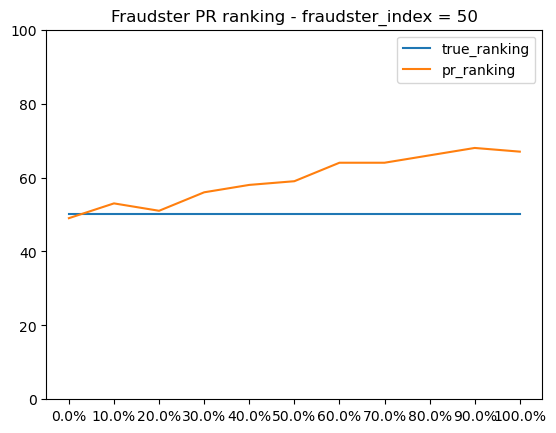

In [315]:
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

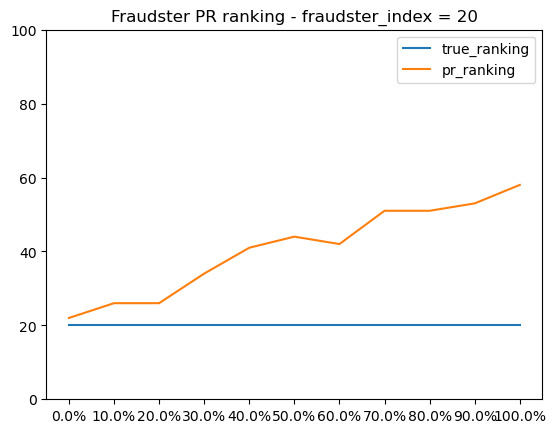

In [308]:
FRAUDSTER_INDEX = 20
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

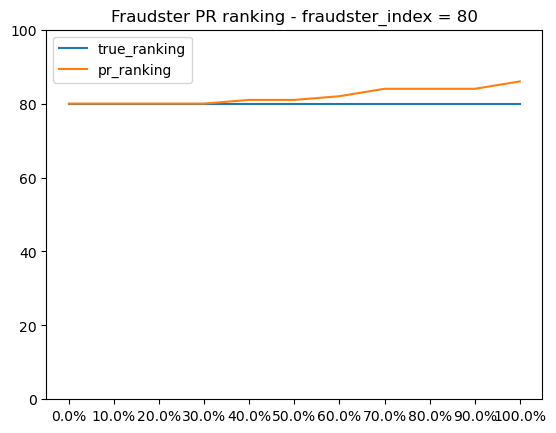

In [309]:
FRAUDSTER_INDEX = 80
list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

We can see that PageRank is fooled by the fraudster. However the lowest its true rating is, the bigger the rank improvement. That can be because the fraudster is dumb ie it selects any weaker opponent.

In [317]:
def compute_judgesCredibility(G, list_fighters, ego=0., credibility_damping_factor=0.85):
    """Compute the credibility values for all nodes in the network

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        ego (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    l = []
    for fighter in list_fighters:
        G_fighter = G.copy().to_undirected()
        G_fighter.remove_nodes_from([x for x in list_fighters if x != fighter])
        d = nx.pagerank(G_fighter, personalization={fighter:1}, alpha=credibility_damping_factor, max_iter=10000)
        d.pop(fighter)
        s = pd.Series(d, name=fighter)
        l.append(s)
    df = pd.concat(l, axis=1)

# compute a hadamard product to have an aggregated credibility by node in the graph
    df["credibility"] = df.product(axis=1)
    df["credibility"] = df["credibility"]/(df["credibility"].max())

# add row for each fight in list_fighters since they were missing
    max_credibility = df["credibility"].max()
    for fighter in list_fighters:
        row = {fighter:df[fighter].max()*ego, "credibility":max_credibility*ego}
        for opponent in [x for x in list_fighters if x != fighter]:
            row[opponent] = 0
        df.loc[fighter] = row
    return df

# add nodes attributes to original G : global and marginal credibilities
def add_credibilityToNetwork(df, G):
    G_res = G.copy()
    for col in df.columns:
        d = dict(df[col])
        nx.set_node_attributes(G_res, {k:{col:v} for k,v in d.items()})
    return G_res

def get_relativeStrength(G, list_fighters, damping_factor=0.85):
    pr = nx.pagerank(G, personalization=nx.get_node_attributes(G, "credibility"), alpha=damping_factor, max_iter=10000)
    return pd.Series(pr).loc[list_fighters]

def compute_relativeStrength(G, list_fighters, ego=0.):
    """Compute the strength of nodes in list_fighters

    Args:
        G (nx.Digraph): network of contacts
        list_fighters (list): nodes to rank
        ego (float, optional): hyperparameter that determines the balance between the fighter's own importance and their judge's importance. Defaults to 0..
    """
    df = compute_judgesCredibility(G, list_fighters, ego)
    G = add_credibilityToNetwork(df, G)
    return get_relativeStrength(G, list_fighters), G

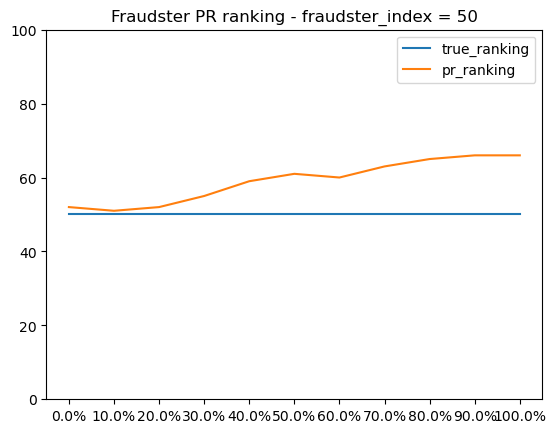

In [316]:
N = 100
P = 10/N
DISTRIBUTION = uniform

FRAUD = True
FRAUD_PROBABILITY = 0.7
FRAUDSTER_INDEX = round(N/2)  # or round(N/2)
FRAUDSTER_STRENGTH = None  # or DISTRIBUTION.expect()
FRAUD_SCHEME = None  # "strength" or None

STRENGTH_SCHEME = False
ITERATIONS = 10000  # strength scheme iterations
DECREASING_FUNCTION = lambda x : power_law(x, 3)  # decreasing function for strength scheme

list_fraud_probabilities = [round(x,2) for x in list(np.linspace(0,1,11))]
list_series = []
for proba in list_fraud_probabilities:
    l = []
    for _ in range(100):
        G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=proba,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)
        l.append(pd.Series(nx.pagerank(G, alpha=0.85)).sort_index())
    
    list_series.append(pd.concat(l, axis=1).mean(axis=1))
    
plt.title(f"Fraudster PR ranking - fraudster_index = {FRAUDSTER_INDEX}")
plt.plot([FRAUDSTER_INDEX for _ in list_series], label="true_ranking")
plt.plot([(list_series[i].rank()-1)[FRAUDSTER_INDEX] for i in range(len(list_series))], label="pr_ranking")
plt.ylim([0,N])
plt.xticks(range(len(list_fraud_probabilities)), [f"{100*x}%" for x in list_fraud_probabilities])
plt.legend()

In [445]:
FRAUD_PROBABILITY = 0.9
FRAUDSTER_INDEX = 20

G = ap.generate_network(N,
                     P,
                     distribution=DISTRIBUTION,
                     fraud=FRAUD,
                     fraudster_index=FRAUDSTER_INDEX,
                     fraudster_strength=FRAUDSTER_STRENGTH,
                     fraud_probability=FRAUD_PROBABILITY,
                     strength_scheme=STRENGTH_SCHEME,
                     iterations=ITERATIONS,
                     decreasing_function=DECREASING_FUNCTION,
                     fraud_scheme=FRAUD_SCHEME)

s = pd.Series(nx.pagerank(G, alpha=0.85)).sort_index()

In [446]:
(s.rank()-1)[20]

64.0

In [447]:
def get_closestRankedNodes(idx, N, k):
    if k%2 != 0:
        raise ValueError("k must be even")
    if idx - k/2 < 0:
        return list(range(0,idx)) + list(range(idx+1,idx + int(k/2) + 1 + abs(idx - int(k/2))))
    if idx + k/2 > N-1 :
        return list(range(idx - int(k/2)- abs(idx + int(k/2) - N + 1),idx)) + list(range(idx+1,N))
    else:
        return list(range(idx - int(k/2),idx)) + list(range(idx+1,idx + int(k/2) + 1))
    
neighborhood = pd.Series(range(N)).apply(lambda x : get_closestRankedNodes(x, N, 4))
neighborhood.head()

0    [1, 2, 3, 4]
1    [0, 2, 3, 4]
2    [0, 1, 3, 4]
3    [1, 2, 4, 5]
4    [2, 3, 5, 6]
dtype: object

In [448]:
ranking = np.array(list((s.rank()-1).sort_values().index))
ranking

array([ 0,  1,  2,  3,  4,  5, 22,  7,  9, 10, 11, 13, 16, 12,  8, 18, 34,
       14, 21,  6, 36, 15, 17, 37, 28, 25, 23, 32, 24, 33, 59, 45, 69, 40,
       43, 19, 38, 30, 26, 35, 48, 41, 29, 42, 57, 31, 44, 47, 46, 27, 68,
       49, 65, 62, 51, 66, 50, 53, 55, 56, 64, 39, 52, 72, 20, 60, 61, 76,
       79, 82, 58, 74, 98, 86, 81, 84, 73, 63, 54, 83, 70, 71, 77, 78, 89,
       94, 67, 75, 85, 87, 88, 92, 90, 80, 91, 93, 97, 95, 96, 99])

In [453]:
compute_relativeStrength(G,[96, 99],ego=0.)

(96    0.083541
 99    0.082272
 dtype: float64,
 <networkx.classes.digraph.DiGraph at 0x1e8fa9d6860>)

In [449]:
l_cpr = []
for i, node in enumerate(ranking):
    neighbors = ranking[neighborhood[i]]
    l = []
    for neighbor in neighbors:
        cpr_node, cpr_neighbor = compute_relativeStrength(G,[node, neighbor],ego=0.)[0].values
        l.append(cpr_neighbor - cpr_node)
    l_cpr.append(l)

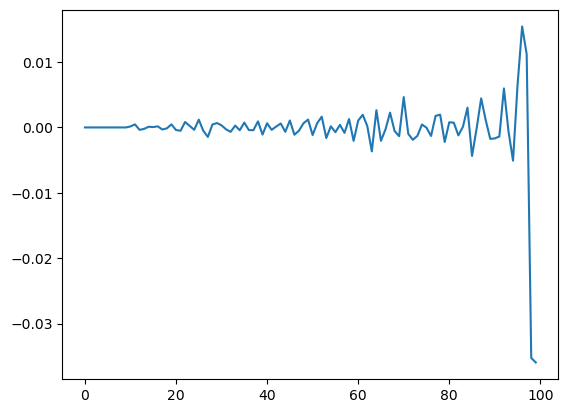

In [450]:
plt.plot(np.array(l_cpr).mean(axis=1))

In [350]:
compute_relativeStrength(G, [50, 64], ego=0.)

(50    0.009058
 64    0.011656
 dtype: float64,
 <networkx.classes.digraph.DiGraph at 0x1e889f26560>)